# Project: ICD-AIS conversion using Deep Learning

### This script creates sparse matrices for the input and output files and creates a neural net using that data

## Setup

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
import time

import modules.helper_functions_800 as hlp800
import modules.helper_functions_200 as hlp200

In [2]:
ais_train_file = "../Data/train_ais_agecat_I9_A05.csv"
icd_train_file ="../Data/train_icd_agecat_I9_A05.csv"
ais_val_file = "../Data/val_ais_agecat_I9_A05.csv"
icd_val_file ="../Data/val_icd_agecat_I9_A05.csv"
ais_test_file = "../Data/test_ais_agecat_I9_A05.csv"
icd_test_file ="../Data/test_icd_agecat_I9_A05.csv"

ais_codes_file = "../Data/AIS08_codes.csv"
ais_map_file = "../Results/test_ais_pred_aaam_map.csv"

MODEL_ROOT_PATH = '/home/qdy4zt/ICD_to_AIS_playground/Models/' # Path that models will be stored in

In [3]:
icd_train = pd.read_csv(icd_train_file, header=None, names=["icd_code"])
icd_val = pd.read_csv(icd_val_file, header=None, names=["icd_code"])
icd_test = pd.read_csv(icd_test_file, header=None, names=["icd_code"])
ais_train = pd.read_csv(ais_train_file, header=None, names=["icd_code"])
ais_val = pd.read_csv(ais_val_file, header=None, names=["icd_code"])
ais_test = pd.read_csv(ais_test_file, header=None, names=["icd_code"])

# load mapped values
ais_map = pd.read_csv(ais_map_file, header=None, skip_blank_lines=False, names=["AIS05CODE"])
# load AIS codes
ais_codes_file = "../Data/AIS08_codes.csv" # This maps AIS08 to AIS98
ais_codes_df = pd.read_csv(ais_codes_file, header=0, encoding='iso-8859-1')
# Make dictionary of codes to get full code with post dot from just the predot
# get predot code
ais_codes_df['predot'] = ais_codes_df.code.apply(lambda x: math.floor(x))
ais_dot = hlp200.get_ais_dot_map(ais_codes_df)

## Retrieve all data to train the neural net

### Only use this if you want to skip to [creating a neural net](#neural_net) with a new kernel as opposed to running the whole notebook again.

In [4]:
%store -r icd_codes
icd_dict = dict(zip(icd_codes, list(range(len(icd_codes)))))

%store -r ais_codes
ais_dict = dict(zip(ais_codes, list(range(len(ais_codes)))))

%store -r spliced_icd_train
%store -r spliced_icd_test
%store -r spliced_icd_val

%store -r spliced_ais_train
%store -r spliced_ais_test
%store -r spliced_ais_val

# Create inverted dicts to test validity
icd_inverted_dict = {v: k for k, v in icd_dict.items()}
ais_inverted_dict = {v: k for k, v in ais_dict.items()}

## Set batch size

### Changing the batch size means you must [recreate sparse matrices](#CreateSparse) 
### I don't recommend changing the batch size

In [5]:
# Decide on a batch size for training neural net
# This is up here to create an array of spliced sparse matrices based on batch size
batch_size = 1000 

### Decide if you want to train with diagnosis ICD codes only or to remove age codes

In [6]:
only_d_codes = False 
remove_age = False # If going with only D codes, no need to set this

## Extract all unique patient ICD and AIS codes

In [7]:
%%time
# get unique icd codes from all sets
icd_codes = hlp800.get_unique_codes([icd_train, icd_val, icd_test], only_d_codes, remove_age)
%store icd_codes

KeyboardInterrupt: 

In [13]:
# create dictionary of ICD codes
icd_dict = dict(zip(icd_codes, list(range(len(icd_codes)))))

In [14]:
print(icd_dict)

{'A10_19': 0, 'A20_29': 1, 'A30_39': 2, 'A40_49': 3, 'A50_59': 4, 'A60_69': 5, 'A70_79': 6, 'A80_89': 7, 'D006.6': 8, 'D008.45': 9, 'D008.8': 10, 'D011.7': 11, 'D011.90': 12, 'D012.86': 13, 'D017.0': 14, 'D027.2': 15, 'D031.0': 16, 'D031.2': 17, 'D031.9': 18, 'D032.85': 19, 'D033.0': 20, 'D034.1': 21, 'D037': 22, 'D038.0': 23, 'D038.10': 24, 'D038.11': 25, 'D038.12': 26, 'D038.19': 27, 'D038.2': 28, 'D038.3': 29, 'D038.40': 30, 'D038.41': 31, 'D038.42': 32, 'D038.43': 33, 'D038.44': 34, 'D038.49': 35, 'D038.8': 36, 'D038.9': 37, 'D039.8': 38, 'D040.0': 39, 'D040.1': 40, 'D041.00': 41, 'D041.01': 42, 'D041.02': 43, 'D041.04': 44, 'D041.05': 45, 'D041.09': 46, 'D041.10': 47, 'D041.11': 48, 'D041.12': 49, 'D041.19': 50, 'D041.2': 51, 'D041.3': 52, 'D041.49': 53, 'D041.5': 54, 'D041.6': 55, 'D041.7': 56, 'D041.82': 57, 'D041.83': 58, 'D041.84': 59, 'D041.85': 60, 'D041.86': 61, 'D041.89': 62, 'D041.9': 63, 'D042': 64, 'D046.19': 65, 'D046.3': 66, 'D048': 67, 'D049.8': 68, 'D052.9': 69, 'D0

In [15]:
%%time
# get unique ais codes from all sets
ais_codes = hlp800.get_unique_codes([ais_train, ais_val, ais_test])
%store ais_codes

Stored 'ais_codes' (list)
CPU times: user 5min 39s, sys: 8.09 s, total: 5min 47s
Wall time: 5min 21s


In [16]:
# create dictionary of AIS codes
ais_dict = dict(zip(ais_codes, list(range(len(ais_codes)))))

<a id='CreateSparse'></a>
## Create sparse matrices
#### Run the two below lines when changing batch size

### Create training, testing, and validation ICD matrices

In [7]:
%%time

print('Creating training matrices...')
row, col, data = hlp800.decode_df_coo(icd_train, icd_dict, only_d_codes, remove_age)
print("Number patients " + str(len(icd_train)))
spliced_icd_train = hlp800.get_list_of_spliced_matrices(row, col, data, len(icd_train), icd_dict, batch_size)
length = 0
for mat in spliced_icd_train:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))

print('\nCreating testing matrices...')
row, col, data = hlp800.decode_df_coo(icd_test, icd_dict, only_d_codes, remove_age)
print("Number patients " + str(len(icd_test)))
spliced_icd_test = hlp800.get_list_of_spliced_matrices(row, col, data, len(icd_test), icd_dict, batch_size)
length = 0
for mat in spliced_icd_test:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))
print(spliced_icd_test[-1].shape)

print('\nCreating validation matrices...')
row, col, data = hlp800.decode_df_coo(icd_val, icd_dict, only_d_codes, remove_age)
print("Number patients " + str(len(icd_val)))
spliced_icd_val = hlp800.get_list_of_spliced_matrices(row, col, data, len(icd_val), icd_dict, batch_size)
length = 0
for mat in spliced_icd_val:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))


%store spliced_icd_train
%store spliced_icd_test
%store spliced_icd_val

Creating training matrices...
['D873.0', 'D852.01', 'P88.38', 'E814.7', 'P88.38', 'A60_69', 'P87.41', 'P88.01', 'P87.03']
Missing codes length: 155
Number patients 895455
Length of all sparse matrices together: 896000

Creating testing matrices...
['D850.0', 'P87.44', 'E880.9', 'P87.03', 'A70_79']
Missing codes length: 3483
Number patients 99717
Length of all sparse matrices together: 100000
torch.Size([1000, 9178])

Creating validation matrices...
['D910.0', 'D959.11', 'A40_49', 'P93.54', 'E816.2', 'D916.0', 'D919.0', 'P96.59', 'D810.00', 'P89.52', 'D807.00']
Missing codes length: 7776
Number patients 2000
Length of all sparse matrices together: 2000
Stored 'spliced_icd_train' (list)
Stored 'spliced_icd_test' (list)
Stored 'spliced_icd_val' (list)
CPU times: user 7min 32s, sys: 13.9 s, total: 7min 46s
Wall time: 6min 23s


### Create training, testing, and validation AIS matrices

In [8]:
%%time

row, col, data = hlp800.decode_df_coo(ais_train, ais_dict)
print('Creating training matrices...')
print("Number patients " + str(len(ais_train)))
spliced_ais_train = hlp800.get_list_of_spliced_matrices(row, col, data, len(ais_train), ais_dict, batch_size)
length = 0
for mat in spliced_ais_train:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))

print("\nCreating testing matrices...")
row, col, data = hlp800.decode_df_coo(ais_test, ais_dict)
print("Number patients " + str(len(ais_test)))
spliced_ais_test = hlp800.get_list_of_spliced_matrices(row, col, data, len(ais_test), ais_dict, batch_size)
length = 0
for mat in spliced_ais_test:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))

print("\nCreating validation matrices...")
row, col, data = hlp800.decode_df_coo(ais_val, ais_dict)
print("Number patients " + str(len(ais_val)))
spliced_ais_val = hlp800.get_list_of_spliced_matrices(row, col, data, len(ais_val), ais_dict, batch_size)
print("Length of all sparse matrices together: " +  str(len(spliced_ais_val[0])))


%store spliced_ais_train
%store spliced_ais_test
%store spliced_ais_val

['140694', '110602']
Missing codes length: 0
Creating training matrices...
Number patients 895455
Length of all sparse matrices together: 896000

Creating testing matrices...
['161001']
Missing codes length: 111
Number patients 99717
Length of all sparse matrices together: 100000

Creating validation matrices...
['442999', '750500', '450200', '810202', '710202', '210202']
Missing codes length: 1118
Number patients 2000
Length of all sparse matrices together: 1000
Stored 'spliced_ais_train' (list)
Stored 'spliced_ais_test' (list)
Stored 'spliced_ais_val' (list)
CPU times: user 6min 18s, sys: 9.91 s, total: 6min 27s
Wall time: 5min 41s


## Test validity of create sparse matrices

In [8]:
%%time

# Create inverted dicts to test validity
icd_inverted_dict = {v: k for k, v in icd_dict.items()}
ais_inverted_dict = {v: k for k, v in ais_dict.items()}

CPU times: user 1.1 ms, sys: 2 µs, total: 1.1 ms
Wall time: 1.1 ms


In [ ]:
%%time
ne, matrix_df = hlp800.test_sparse_matrix(sparse_icd_train, icd_train, icd_inverted_dict)
hlp800.print_diff(ne)

In [7]:
%%time
ne, matrix_df = hlp800.test_sparse_matrices(spliced_icd_test, icd_test, icd_inverted_dict)
hlp800.print_diff(ne)

Dataframes are identical


In [59]:
%%time
ne, matrix_df = hlp800.test_sparse_matrices(spliced_icd_val, icd_val, icd_inverted_dict)
hlp800.print_diff(ne)

Dataframes are identical
CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 291 ms


In [41]:
%%time
ne, matrix_df = hlp800.test_sparse_matrices(spliced_ais_train, ais_train, ais_inverted_dict)
hlp800.print_diff(ne)

KeyboardInterrupt: 

In [14]:
%%time
ne, matrix_df = hlp800.test_sparse_matrices(spliced_ais_test, ais_test, ais_inverted_dict)
hlp800.print_diff(ne)

Dataframes are identical
CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s


In [15]:
%%time
ne, matrix_df = hlp800.test_sparse_matrices(spliced_ais_val, ais_val, ais_inverted_dict)
hlp800.print_diff(ne)

Dataframes are identical
CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 176 ms


## Load model by name

### Run this line if you want to run a premade model as opposed to making a new one

#### Skip [here](#test) to test model

In [16]:
# Change model name here
MODEL_NAME = 'BCE-Adagrad-shuffled-pts-M1'

try:
    model = torch.load(MODEL_ROOT_PATH+MODEL_NAME)
    model.to(device)
except:
    # Load for the first time
    model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
    model.load_state_dict(torch.load(MODEL_ROOT_PATH+MODEL_NAME))
    model.to(device)

<a id='neural_net'></a>
## Set up neural net training

In [7]:
# Set model name here
MODEL_NAME = 'BCE-Adagrad-shuffled-pts-M1'

In [8]:
# Set parameters...
# For training
learning_rate = 0.025
num_epochs = 250
# For neural net
input_size = len(icd_dict)
num_classes = len(ais_dict)
print(input_size)
print(num_classes)

9178
1983


In [9]:
# Try to run on GPU else run on CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)

Using cuda device


### Create a neural net class

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__() # Init the superclass nn.Module
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)), 
            nn.ReLU(),
            nn.Linear(int(input_size/2), num_classes), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        r = self.linear_relu_stack(x)
        return r

### Create a dataset and a dataloader

In [11]:
class SparseMatrixDataset(Dataset):
    def __init__(self, spliced_icd, spliced_ais):
        self.icd_spliced = spliced_icd
        self.ais_spliced = spliced_ais
        self.count = 0
        self.length = len(self.icd_spliced)
        if self.icd_spliced[0].shape != self.icd_spliced[1].shape:
            self.length = self.length - 1

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):  
        # Get indices for icd and ais and return
        self.count += 1
        return self.icd_spliced[self.count-1], self.ais_spliced[self.count-1]

In [12]:
# Create dataloader using dataset
train_loader = DataLoader(dataset=SparseMatrixDataset(spliced_icd_train, spliced_ais_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=SparseMatrixDataset(spliced_icd_val, spliced_ais_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=SparseMatrixDataset(spliced_icd_test, spliced_ais_test), batch_size=batch_size, shuffle=True)

## Creating a neural net and training it

### Create the model and set up training

In [13]:
# Init network
model = NeuralNetwork(input_size=input_size, num_classes=num_classes).to(device)

# Set loss and optimizer
loss_function = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(),lr=learning_rate)

### Train Neural Net

In [ ]:
%%time
# To Do:
import random

# Set flags
is_first_model_save = True # Flag to let us know if this is the first save of the model
num_epochs_not_improved = 0 # number of epochs without improvement
count_lr_decays = 0 # amount of times lr was decreased

# Set paramaters
lr_decay_factor_decrease = 5 # amount lr is divided by each time it's decreased
lr_decay_threshold = 2 # Threshold of epochs without improvement before decaying learning rate
max_number_lr_decays = 10 # Amount of learning rate factor decreases we will allow

# Preset global vars
list_training_matrices = [] # List to hold training data sparse matrices and allow for shuffling 
best_val_loss = 1 # Best loss score of validation data so far
val_losses = [] # List of losses from each of the past epochs

# Train the net work
model.train()
for epoch in range(num_epochs):
    print('\n\nStarting epoch #' + str(epoch+1) + '...')
    print('Training data...')
    train_loader.dataset.count = 0
    for batch_index, (icds, aiss) in enumerate((train_loader)):
        # If haven't set the list_training_matrices, lets do that then we can shuffle
        if list_training_matrices == []:
            list_training_matrices = list(range(0, len(icds)))
        random.shuffle(list_training_matrices) # Shuffle the batches automatically
        for idx in range(0, len(icds)):
            print("On batch " + str(idx+1) + " / " + str(len(icds)), end="\r")
            # Turn sparse batch to dense
            icd_batch = icds[list_training_matrices[idx]].to_dense()
            ais_batch = aiss[list_training_matrices[idx]].to_dense()
            
            # Shuffle rows
            indices = torch.randperm(icd_batch.size()[0])
            icd_batch = icd_batch[indices]
            ais_batch = ais_batch[indices]          
            
            # Forwards propogation
            scores = model(icd_batch.cuda())
            loss = loss_function(scores, ais_batch.cuda())
            
            # Clean up 
            del icd_batch
            del ais_batch
            del scores
            
            # Backwards propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print('Training loss at epoch number ' + str(epoch+1) + ' is ' + str(float(loss)))
     
    print('\nValidating data...')
    new_val_losses = [] # List of losses for this epoch      
    # Validation data don't train, just see where u are after each epoch # When validating round up/down
    val_loader.dataset.count = 0
    for batch_index, (icds, aiss) in enumerate((val_loader)):
        for idx in range(0, len(icds)):
            print("On batch " + str(idx+1) + " / " + str(len(icds)), end="\r")
            icd_batch = icds[idx].to_dense()
            ais_batch = aiss[idx].to_dense()
            # forward propagation
            scores = model(icd_batch.cuda())
            loss = loss_function(scores, ais_batch.cuda())
            new_val_losses.append(loss.item())
            del icd_batch
            del ais_batch
            del scores
            del loss
    avg_new_val_loss = sum(new_val_losses) / len(new_val_losses)
    
    # Check if we are getting a less accurate model
    if len(val_losses) > 0:
        print("Best val loss : " + str(best_val_loss))
        print("Current val loss: " + str(avg_new_val_loss))
        if avg_new_val_loss >= best_val_loss:
            print("Model worsened...returning to best model")
            num_epochs_not_improved += 1
            val_losses.append(avg_new_val_loss)
            # Reset model to the best one with the lowest loss
            try:
                model = torch.load(MODEL_ROOT_PATH+MODEL_NAME)
                model.to(device)
            except:
                # Load for the first time
                model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
                model.load_state_dict(torch.load(MODEL_ROOT_PATH+MODEL_NAME))
                model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            if num_epochs_not_improved >= lr_decay_threshold:
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                print("Model is worsening...Returning to best model and decaying learning rate")
                for g in optimizer.param_groups:
                    learning_rate = g['lr']/lr_decay_factor_decrease
                    g['lr'] = learning_rate
                    print("New learning rate is " + str(learning_rate))
                num_epochs_not_improved = 0
                count_lr_decays += 1
            if count_lr_decays > max_number_lr_decays:
                break
        else:
            best_val_loss = avg_new_val_loss
            num_epochs_not_improved = 0
            print("Model continuing to improve... saving state")
            # Then save the model
            if is_first_model_save:
                # Store trained model for the first time
                # https://stackoverflow.com/a/43819235/16393363
                torch.save(model.state_dict(), MODEL_ROOT_PATH+MODEL_NAME)
            else: 
                # Save entire model
                torch.save(model, MODEL_ROOT_PATH+MODEL_NAME)
            val_losses.append(avg_new_val_loss)
    else:
        best_val_loss = avg_new_val_loss
        val_losses.append(avg_new_val_loss)

# Done training get last best model
try:
    model = torch.load(MODEL_ROOT_PATH+MODEL_NAME)
    model.to(device)
except:
    # Load for the first time
    model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
    model.load_state_dict(torch.load(MODEL_ROOT_PATH+MODEL_NAME))
    model.to(device)



Starting epoch #1...
Training data...
Training loss at epoch number 1 is 0.02855192869901657

Validating data...
On batch 2 / 2

Starting epoch #2...
Training data...
Training loss at epoch number 2 is 0.0172822754830122

Validating data...
Best val loss : 0.024403675459325314
Current val loss: 0.016733461059629917
Model continuing to improve... saving state


Starting epoch #3...
Training data...
Training loss at epoch number 3 is 0.013593096286058426

Validating data...
Best val loss : 0.016733461059629917
Current val loss: 0.013719323556870222
Model continuing to improve... saving state


Starting epoch #4...
Training data...
Training loss at epoch number 4 is 0.012353240512311459

Validating data...
Best val loss : 0.013719323556870222
Current val loss: 0.012029487639665604
Model continuing to improve... saving state


Starting epoch #5...
Training data...
Training loss at epoch number 5 is 0.010060080327093601

Validating data...
Best val loss : 0.012029487639665604
Current val 

<a id='test'></a>
## Evaluate the trained neural net

### Analyze losses

In [94]:
%store val_losses

Stored 'val_losses' (list)


In [95]:
%store -r val_losses

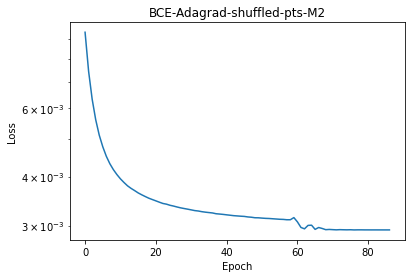

In [96]:
# Plot on log scale
t = np.asarray(val_losses)
plt.plot(np.asarray([x for x in range(0, len(t))]), (t))
plt.ylabel('Loss')
plt.yscale("log") 
plt.xlabel('Epoch')
plt.title(MODEL_NAME)
plt.show()

## View attention for model created
#### Works only if no layers of abstraction at the current moment


In [97]:
# View attention for model created, works only if no layers of abstraction at the current moment
num_pts_to_eval = 3 # Look at the first 3 patients only
hlp800.view_attention(icd_test, icd_dict, icd_inverted_dict, 
                      ais_test, ais_dict, ais_inverted_dict, 
                      model, only_d_codes, remove_age,
                      num_pts_to_eval
                     )

ICD codes ['A70_79', 'E880.9', 'P87.03', 'P87.44', 'D850.0'] should have resulted in ['161001']


For ais code 161001
A70_79 Attention: 2.15% and increased final score
E880.9 Attention: 40.25% and increased final score
P87.03 Attention: 7.47% and increased final score
P87.44 Attention: 11.58% and increased final score
D850.0 Attention: 38.55% and increased final score
Final score: 0.5301554203033447
_________________________________________________________________




ICD codes ['A50_59', 'E884.9', 'P-2', 'D805.2', 'D805.4', 'D807.03'] should have resulted in ['450203', '650416', '650630']


For ais code 450203
A50_59 Attention: 1.59% and decreased final score
E884.9 Attention: 2.18% and decreased final score
P-2 Attention: 79.67% and decreased final score
D805.2 Attention: 0.71% and decreased final score
D805.4 Attention: 8.53% and increased final score
D807.03 Attention: 7.33% and decreased final score
Final score: 0.48129764199256897


For ais code 650416
A50_59 Attention: 21.08% an

### Test Neural Net With Testing Data

In [17]:
import collections

# Testing parameters
score_cut_off = 0.3 # Cut off score, above which will be 1, below will be 0

# Load model and test
try:
    model = torch.load(MODEL_ROOT_PATH+MODEL_NAME)
    model.to(device)
except:
    # Load for the first time
    model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
    model.load_state_dict(torch.load(MODEL_ROOT_PATH+MODEL_NAME))
    model.to(device)
    
scores_list = []
print('Testing with testing data...')
test_loader.dataset.count = 0
model.eval()
for batch_index, (icds, aiss) in enumerate((test_loader)):
    for idx in range(0, len(icds)):
            print("On batch " + str(idx+1) + " / " + str(len(icds)), end="\r")
            icd_batch = icds[idx].to_dense()
            ais_batch = aiss[idx].to_dense()
            # forward
            scores = model(icd_batch.cuda())
            scores = (scores>=score_cut_off).float()
            scores_list.append(scores)


Testing with testing data...


### Create a dataframe that shows the observations and prediction AIS codes for each patient, along with ICD codes

In [18]:
%%time
# Check accuracy 200s write code to be able to compoare to other methods
# Start by recreating the dataframe ais_test from our data
df_rows_list = []
batch_index = 0 # Index of the batch we are on
# In each batch get the list of scores for each pt
for batch_scores in scores_list:
    batch_multiplier = batch_index * batch_size # Used to map to the pt number in ais_test/icd_test
    pt_num_from_batch = 0 # Used to map to pt row number
    for pts_score in batch_scores:
        abs_pt_num = batch_multiplier + pt_num_from_batch
        # If we have gotten to the dummy pts used to round out sparse coo matrix size, then exit
        if abs_pt_num >= len(icd_test):
            break
        pt_row_dictionary = {}
        # Get the keys to ais codes for each pt, can have may ais codes
        pt_ais_codes_keys = (pts_score == 1).nonzero(as_tuple=False).tolist()
        ais_code_str = ''
        # For each code in patient's predicted ais codes map and append code to string
        for ais_code_key in pt_ais_codes_keys:
            ais_code = ais_inverted_dict[int(ais_code_key[0])]
            ais_code_str = ais_code_str + str((ais_code)) + ' '
        # Gather data for making ais_test_predictions_df
        try: # For some reason AIS_map is 1 pt shorter than ais_test and icd_test
            pt_row_dictionary['ICD9CODE'] = icd_test.iloc[abs_pt_num][0]
            if ais_code_str == '':
                #print(abs_pt_num)
                pt_row_dictionary['AIS_pred'] = np.NaN
            else:
                pt_row_dictionary['AIS_pred'] = ais_code_str[0:-1]
            pt_row_dictionary['AIS_obs'] = ais_test.iloc[abs_pt_num][0]
            pt_row_dictionary['AIS_map'] = ais_map.iloc[abs_pt_num][0]
            df_rows_list.append(pt_row_dictionary)
            pt_num_from_batch += 1
        except:
            print('Done...')
            break
    batch_index += 1
    
        
    
ais_test_predictions_df = pd.DataFrame(df_rows_list, columns=['ICD9CODE', 'AIS_obs', 'AIS_pred', 'AIS_map']) 
ais_test_predictions_df = hlp200.process_ais_codes(ais_test_predictions_df, ais_dot)

Done...
CPU times: user 41 s, sys: 489 ms, total: 41.5 s
Wall time: 41.5 s


In [19]:
%store ais_test_predictions_df

Stored 'ais_test_predictions_df' (DataFrame)


In [20]:
%store -r ais_test_predictions_df

In [21]:
ais_test_predictions_df.head(10)

,ICD9CODE,AIS_obs,AIS_pred,AIS_map
0,A70_79 E880.9 P87.03 P87.44 D850.0,[161001.1],[161001.1],[110000.1]
1,A50_59 E884.9 P-2 D805.2 D805.4 D807.03,"[450203.3, 650416.2, 650630.2]","[450203.3, 650420.2, 650620.2]","[420000.3, 620000.2, 630000.2]"
2,A60_69 E885.9 P79.35 P87.03 D820.21,[853151.3],[853151.3],[840000.3]
3,A50_59 E881.0 P88.01 P88.38 D805.4 D823.01 D82...,"[650616.2, 854441.2, 857200.2]","[852004.2, 854471.2]","[630000.2, 840000.2, 840000.2]"
4,A30_39 E986 P54.11 D879.4,[516000.1],[516002.1],[560000.1]
5,A20_29 E885.9 P87.03 P88.38 P96.04 P96.71 D801.22,"[140651.3, 140694.2, 150200.3]",[150202.3],[110000.3]
6,A60_69 E917.3 P79.31 D812.00,[751111.2],[751111.2],[740000.2]
7,A50_59 E885.3 P79.15 D820.22,[853111.3],[853151.3],[840000.3]
8,A80_89 E886.9 P87.03 P87.41 P88.01 P88.38 D852...,"[110602.1, 140438.3]","[110600.1, 110602.1, 140650.3, 140652.4]","[110000.3, 160000.1]"
9,A70_79 E816.0 P87.03 P87.04 P87.41 P88.01 P88....,"[110604.2, 140694.2, 750961.2]","[110604.2, 140694.2, 750961.2]","[110000.2, 160000.1, 740000.2]"


In [22]:
%%time
NUMEXPR_MAX_THREADS = 20

sample_res = ais_test_predictions_df.head(10000)

# loop through all results
for i in range(0,len(sample_res)):
    
    # match up lists of AIS codes
    matches = hlp200.match_ais(sample_res.AIS_obs[i], sample_res.AIS_pred[i])
    
    # check if first iteration
    if i==0:
        # create dataframe for results
        match_results = hlp200.match_stats(matches, ais_codes_df)
        
    else:
        # append results to dataframe
        match_results = match_results.append(hlp200.match_stats(matches, ais_codes_df), ignore_index=True)
        
match_results = sample_res.join(match_results)
match_results.to_csv("../Results/feedforward_ais_check_accuracy_best.csv", index=False)

2022-08-04 19:44:37,228: Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-04 19:44:37,230: NumExpr defaulting to 8 threads.
CPU times: user 8min 44s, sys: 809 ms, total: 8min 45s
Wall time: 8min 44s


num_obs     2.8856
num_pred    3.0747
dtype: float64


<AxesSubplot:>

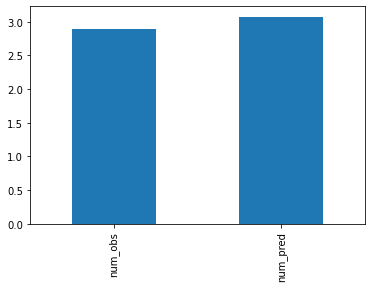

In [23]:
# mean number of injuries per patient
print(match_results[['num_obs','num_pred']].mean())
match_results[['num_obs','num_pred']].mean().plot.bar()

In [24]:
# ISS results
print("ISS equal:", match_results.iss_equal.mean())
print("ISS >=16 equal:", match_results.iss_16_equal.mean())

ISS equal: 0.7249
ISS >=16 equal: 0.9205


In [25]:
iss_16_mismatch = match_results[match_results.iss_16_equal==0]
print("ISS>=16 underpredicted:", len(iss_16_mismatch[iss_16_mismatch.iss_obs>iss_16_mismatch.iss_pred])/len(iss_16_mismatch))

ISS>=16 underpredicted: 0.7119496855345911


iss_obs     8.798057
iss_pred    7.795854
dtype: float64


<AxesSubplot:>

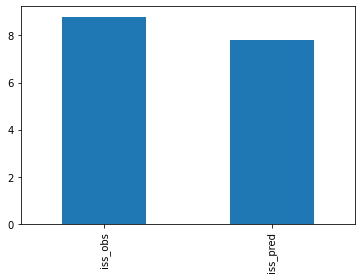

In [26]:
# mean ISS
print(match_results[['iss_obs','iss_pred']].mean())
match_results[['iss_obs','iss_pred']].mean().plot.bar()

In [27]:
# MAIS results
print("MAIS equal:", match_results.mais_equal.mean())
print("MAIS >=3 equal:", match_results.mais_3_equal.mean())

MAIS equal: 0.7898
MAIS >=3 equal: 0.9047


In [28]:
mais_3_mismatch = match_results[match_results.mais_3_equal==0]
print("MAIS>=3 underpredicted:", len(mais_3_mismatch[mais_3_mismatch.mais_obs>mais_3_mismatch.mais_pred])/len(mais_3_mismatch))

MAIS>=3 underpredicted: 0.6736621196222455


mais_obs     2.5149
mais_pred    2.3872
dtype: float64


<AxesSubplot:>

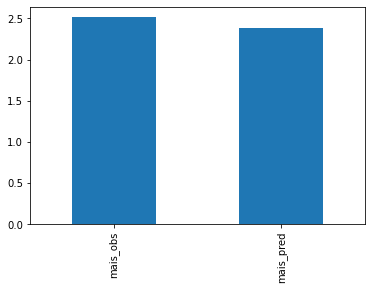

In [29]:
# mean MAIS
print(match_results[['mais_obs','mais_pred']].mean())
match_results[['mais_obs','mais_pred']].mean().plot.bar()

In [31]:
# total codes observed
num_obs = sum(match_results.num_obs)
num_pred = sum(match_results.num_pred)

# match categories
match_cat = pd.DataFrame({'Exact Match':[sum(match_results.exact)/num_obs], \
                          'Same Reg & Severity':[sum(match_results.same_reg_same_sev)/num_obs], \
                          'Same Reg, Diff Severity':[sum(match_results.same_reg_diff_sev)/num_obs], \
                          'Diff Reg, Same Severity':[sum(match_results.diff_reg_same_sev)/num_obs], \
                          'Diff Reg & Severity':[sum(match_results.diff_reg_diff_sev)/num_obs], \
                          'Observations Unmatched':[sum(match_results.unmatched_obs)/num_obs], \
                          'Percent Predictions Unmatched':[sum(match_results.unmatched_pred)/num_pred]})

match_cat

,Exact Match,Same Reg & Severity,"Same Reg, Diff Severity","Diff Reg, Same Severity",Diff Reg & Severity,Observations Unmatched,Percent Predictions Unmatched
0,0.656259,0.165061,0.072498,0.019233,0.013377,0.073953,0.130907


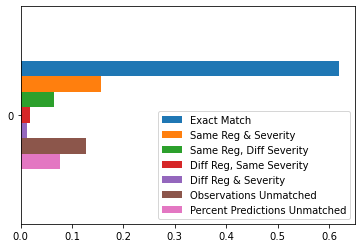

In [130]:
match_cat.plot.barh().invert_yaxis()

(0.0, 0.75)

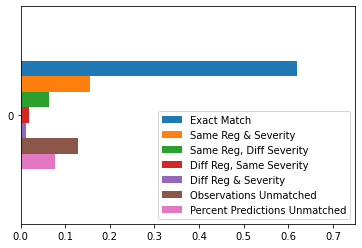

In [131]:
ax = match_cat.plot.barh()
ax.invert_yaxis()
ax.set_xlim(0,0.75)

,Good,Maybe okay,Not great,Poor
0,0.77606,0.064042,0.019129,0.212885


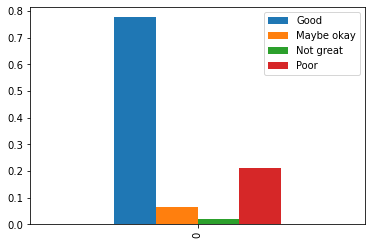

In [132]:
# total codes observed
num_obs = sum(match_results.num_obs)

# match categories
match_cat = pd.DataFrame({'Good':[(sum(match_results.exact) + sum(match_results.same_reg_same_sev))/num_obs], \
                          'Maybe okay':[sum(match_results.same_reg_diff_sev)/num_obs], \
                          'Not great':[sum(match_results.diff_reg_same_sev)/num_obs], \
                          'Poor':[(sum(match_results.unmatched))/num_obs]})

match_cat.plot.bar()
match_cat